<a href="https://colab.research.google.com/github/ulasciftcioglu/Prediction-of-Brain-Region-from-Physiology/blob/master/src/Prediction_of_Brain_Region_from_Physiology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Location of Brain Cells Based on Their Physiological Properties

##Welcome to my notebook. Here we will:

#####*   Download the dataset that contains physiological metrics from brain cells in different brain regions, from the recently released [Allen Brain Neuropixels Dataset](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html)
#####*   Preprocess the Dataset (Filtering, imputation, normalization)
#####*   Build models that can predict the location of brain cells from their physiological parameters
#####*   Look into features which matters most in the prediction
#####*   Compare the prediction performance of 2 datasets ("Brain Observatory 1.1" and "Functional Connectivity") , collected under different experimental settings

####This dataset is collected from cells in various brain regions of mouse, for two experimental protocols which consists of different visual stimuli sequences ("Brain Observatory 1.1" and "Functional Connectivity"). For more information on this dataset and how it is collected, please see [Allen Brain Observatory Visual Coding - Neuropixels Dataset](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html) and the [associated technical whitepaper](https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf).

Here is the abbreviations used throughout the notebook:

vc=Visual Cortex; hf=Hippocampal Formation; bo=Brain Observatory 1.1; fc=Functional Connectivity

#1 - Install Allen Software Development Kit, Download Data and Install/Import libraries

In [1]:
'''
Installation Allen Software Development Kit
Commands provided in Allen Software Development Kit (https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html)
Set directory to download csv files and download these files

After that, install statsmodels version 0.10.2 (to revert the downgrade during the installation of allendsk 0.9.0)
Install hypopt (to do grid search using validation set with scikit-learn models)
Import libraries
'''

!pip install -U allensdk

import os
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

data_directory = '/tmp/AllenBrainDataset' # update directory to preferred directory (optional)
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

metrics_brain_observatory=cache.get_unit_analysis_metrics_by_session_type('brain_observatory_1.1') # Download Brain Observatory Dataset
metrics_functional_connectivity=cache.get_unit_analysis_metrics_by_session_type('functional_connectivity') # Download Functional Connectivity Dataset


!pip install statsmodels==0.10.2
!pip install hypopt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import statsmodels.discrete.discrete_model as dm

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier

from hypopt import GridSearch

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers



     |████████████████████████████████| 1.5MB 3.5MB/s 
     |████████████████████████████████| 1.2MB 20.3MB/s 
     |████████████████████████████████| 2.9MB 36.8MB/s 
     |████████████████████████████████| 42.5MB 76kB/s 
     |████████████████████████████████| 4.3MB 63.8MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 3.4MB 49.2MB/s 
     |████████████████████████████████| 92kB 14.7MB/s 
     |████████████████████████████████| 81kB 14.7MB/s 
     |████████████████████████████████| 7.4MB 32.5MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 102kB 16.8MB/s 
     |████████████████████████████████| 256kB 64.6MB/s 
     |████████████████████████████████| 153kB 71.2MB/s 
     |████████████████████████████████| 133kB 74.2MB/s 
     |████████████████████████████████| 552kB 36.4MB/s 
  Created wheel for argschema: filename=argschema-2.0.1-

/usr/local/lib/python3.6/dist-packages/allensdk/brain_observatory/ecephys/ecephys_project_api/ecephys_project_warehouse_api.py:296: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  pv_is_bool = np.issubdtype(output["p_value_rf"].values[0], bool)


     |████████████████████████████████| 8.1MB 3.4MB/s 
ERROR: allensdk 1.4.0 has requirement statsmodels==0.9.0, but you'll have statsmodels 0.10.2 which is incompatible.
  Found existing installation: statsmodels 0.9.0
    Uninstalling statsmodels-0.9.0:
      Successfully uninstalled statsmodels-0.9.0


#2 - Import Data to Workspace
Read the data csv files as pandas dataframes. Here is the list of 4 files:

1.   brain_observatory_1.1_analysis_metrics.csv: Includes metric values for the "Brain Observatory 1.1" experimental protocol 
2.   functional_connectivity_analysis_metrics.csv: Includes metric values for the "Functional Connectivity" experimental protocol
3.   channels.csv: Includes information (such as brain region) about channels (A Channel corresponds to a recording site (in an electrode) that units are recorded. There can be zero, one or many units (brain cells) recording in a specific channel.)
4.   units.csv: Includes information about units (the associated channel and quality information)






In [2]:
'''
Read all 4 csv files necessary
1-Brain Observatory Dataset, 2-Functional Connectivity Dataset, 3-Channels Information, 4- Units Information 
'''

metrics_brain_observatory=pd.read_csv('/tmp/AllenBrainDataset/brain_observatory_1.1_analysis_metrics.csv',encoding='utf-8')
metrics_functional_connectivity=pd.read_csv('/tmp/AllenBrainDataset/functional_connectivity_analysis_metrics.csv',encoding='utf-8')
channels_data = pd.read_csv('/tmp/AllenBrainDataset/channels.csv',encoding='utf-8')
units_data = pd.read_csv('/tmp/AllenBrainDataset/units.csv',encoding='utf-8')

print('Brain Observatory Dataset contains '+str(metrics_brain_observatory.shape[0])+' samples with '+str(metrics_brain_observatory.shape[1])+' features.')
print('Functional Connectivity Dataset contains '+str(metrics_functional_connectivity.shape[0])+' samples with '+str(metrics_functional_connectivity.shape[1])+' features.')

Brain Observatory Dataset contains 74072 samples with 58 features.
Functional Connectivity Dataset contains 61203 samples with 46 features.


#3 - Data Preprocessing

Define keys to retreive data from different csv files. Filter data points ("unit" refers to a brain cell) labeled as "good" quality. Also store the associated brain structure for each cell.   

In [3]:
'''
Filtering Samples(Units) with Good Quality from Both Datasets
Based on the quality metrics, the units in the dataset is labeled as "good" or "noise" in the file containing units information (units.csv) 
'''

#keys necessary to locate variables in different csv files
unit_id_key_metrics_files='ecephys_unit_id'
unit_id_key_units_file='id'
unit_quality_key_units_file='quality'
channel_id_key_units_file='ecephys_channel_id'
channel_id_key_channels_file='id'
channel_structure_key_channels_file='ecephys_structure_acronym'

def filter_good_data(metrics_data,units_data,channels_data,unit_id_key_metrics_files,unit_id_key_units_file,unit_quality_key_units_file,channel_id_key_units_file,channel_id_key_channels_file,channel_structure_key_channels_file):
  '''
  Filters units only labeled as "good" and with avaiable anatomical information in the Brain Observatory and Functional Connectivity Datasets (1 dataset for each function run)
  1-Use the unit identifier in the Dataset file (Brain Observatory or Functional Connectivity)
  2-Locate the corresponding unit in the Units file
  3-Look at the quality value
  4-If "good", find the associated channel id for the unit (ignore the unit is labeled as "noise")
  5-Locate the channel in the channels file
  6-Look at the structure info
  7-If structure info is present, include the units to the filtered set (ignore the unit if no structure information avaiable ('nan' entry))
  8-Filter the dataset and associated structure information 
  (ignore the unit if none or more than 1 associated entries in the units file, ignore the unit if none or more than 1 associated entries for units's channel in the channels file )
  '''
  structure=[]
  good_units=[]
  number_of_units=metrics_data.shape[0]

  for unit in metrics_data[unit_id_key_metrics_files]:
    unit_in_units_file=units_data[units_data[unit_id_key_units_file]==unit]
    if unit_in_units_file.shape[0]==1:
      if unit_in_units_file[unit_quality_key_units_file].to_numpy()=='good':
        channel=unit_in_units_file[channel_id_key_units_file]
        channnel_in_channels_file=channels_data[channels_data[channel_id_key_channels_file]==(channel.to_numpy()[0])]
        if channnel_in_channels_file.shape[0]==1:
          if (channnel_in_channels_file[channel_structure_key_channels_file].to_numpy().astype(str))!='nan':
            structure.append(channnel_in_channels_file[channel_structure_key_channels_file].to_numpy().astype(str))
            good_units.append(unit)
        elif unit_in_units_file.shape[0]==0:
          print('Warning: No corresponding entry found in channels file for'+str(channel))
        else:
          print('Warning: 2 or more corresponding entries found in channels file for'+str(channel))
    elif unit_in_units_file.shape[0]==0:
      print('Warning: No corresponding entry found in units file for'+str(unit))
    else:
      print('Warning: 2 or more corresponding entries found in units file for'+str(unit))

  good_metrics=metrics_data.loc[metrics_data[unit_id_key_metrics_files].isin(good_units)]
  structure=pd.DataFrame(structure)
  structure.index=good_metrics.index

  return good_metrics,structure

'''
Filter good units with structure information for Brain Observatory and Functional Connectivity Datasets
'''
metrics_brain_observatory_good,structure_brain_observatory=filter_good_data(metrics_brain_observatory,units_data,channels_data,unit_id_key_metrics_files,
                                                                            unit_id_key_units_file,unit_quality_key_units_file,channel_id_key_units_file,channel_id_key_channels_file,channel_structure_key_channels_file)
metrics_functional_connectivity_good,structure_functional_connectivity=filter_good_data(metrics_functional_connectivity,units_data,channels_data,unit_id_key_metrics_files,
                                                                                        unit_id_key_units_file,unit_quality_key_units_file,channel_id_key_units_file,channel_id_key_channels_file,channel_structure_key_channels_file)

print('For Brain Observatory Dataset, '+str(metrics_brain_observatory_good.shape[0])+' good units out of '+str(metrics_brain_observatory.shape[0])+' units.'  )
print('For Functional Connectivity Dataset, '+str(metrics_functional_connectivity_good.shape[0])+' good units out of '+str(metrics_functional_connectivity.shape[0])+' units.'  )


For Brain Observatory Dataset, 54107 good units out of 74072 units.
For Functional Connectivity Dataset, 45013 good units out of 61203 units.


Define the brain regions of interest. In this notebook, we're going to work with data from visual cortex and hippocampal formation. Visual cortex and hippocampal formation includes divisions. Associated set of labels are created based on the [Allen Mouse Brain Atlas](http://atlas.brain-map.org/atlas?atlas=1#atlas=1&plate=100960224&structure=549&x=5280.001395089286&y=3743.886369977679&zoom=-3&resolution=11.97&z=5). 

In [4]:
'''
Assign the labels for brain structures to be focused on this study
7 brain structures in the visual cortex (Structures part of "Visual Areas" In Allen Mouse Brain Atlas)
7 brain structures in the hippocampal formation (Structures part of "Hippocampal Formation" In Allen Mouse Brain Atlas, together with "HPF" (Hippocampal Formation), overall 7+1=8 labels)
'''

visual_cortex_labels=["VISp","VISal","VISam","VISrl","VISl","VISpm","VISli"]
hippocampal_formation_labels=["CA1","DG","CA3","CA2","SUB","ProS","HPF","PRE"]

def filter_by_structure(good_metrics,structure,visual_cortex_labels,hippocampal_formation_labels):
  '''
  Filter units that are either in visual cortex and hippocampal formation (Based on the set of labels defined earlier) from both datasets
  Output 2 sets (1 for visual cortex, 1 for hippocampal formation) from a single dataset (that contains units from many brain structures)
  '''
  good_metrics_visual_cortex=good_metrics.loc[structure[0].isin(visual_cortex_labels)]
  good_metrics_hippocampal_formation=good_metrics.loc[structure[0].isin(hippocampal_formation_labels)]
  return good_metrics_visual_cortex,good_metrics_hippocampal_formation


'''
Filter units in the visual cortex or hippocampal formation for Brain Observatory and Functional Connectivity Datasets
'''
metrics_brain_observatory_visual_cortex,metrics_brain_observatory_hippocampal_formation=filter_by_structure(metrics_brain_observatory_good,structure_brain_observatory,
                                                                                                            visual_cortex_labels,hippocampal_formation_labels)
metrics_functional_connectivity_visual_cortex,metrics_functional_connectivity_hippocampal_formation=filter_by_structure(metrics_functional_connectivity_good,structure_functional_connectivity,
                                                                                                                        visual_cortex_labels,hippocampal_formation_labels)

print('For Brain Observatory Dataset, '+str(metrics_brain_observatory_visual_cortex.shape[0])+' visual cortex units.')
print('For Brain Observatory Dataset, '+str(metrics_brain_observatory_hippocampal_formation.shape[0])+' hippocampal formation units.')
print('For Functional Connectivity Dataset, '+str(metrics_functional_connectivity_visual_cortex.shape[0])+' visual cortex units.')
print('For Functional Connectivity Dataset, '+str(metrics_functional_connectivity_hippocampal_formation.shape[0])+' hippocampal formation units.')

For Brain Observatory Dataset, 19419 visual cortex units.
For Brain Observatory Dataset, 12442 hippocampal formation units.
For Functional Connectivity Dataset, 17669 visual cortex units.
For Functional Connectivity Dataset, 17382 hippocampal formation units.


Match the sample sizes for each brain region (visual cortex and hippocampal formation) in the 2 different datasets ("Brain Observatory 1.1" and "Functional Connectivity"). This will eliminate possible bias from unmatched class sizes when comparing the prediction performance from data of different experimental settings. 

In [5]:
'''
  Match datasets sizes to eliminate bias from number of samples sizes (for each brain region) associated with 2 datasets
'''
def match_dataset_sizes(dataset1,dataset2):
  '''
  Match datasets sizes from both datasets (Brain Observatory and Functional Connectivity Datasets)
  For each brain structure (visual cortex or hippocampal formation), remove samples from the set which has more samples to equalize sample sizes for each structure
  '''
  dataset1_size=dataset1.shape[0]
  dataset2_size=dataset2.shape[0]
  
  if dataset1_size>dataset2_size:
    dataset2_matched=dataset2
    dataset1_shuffled=dataset1.sample(frac=1)
    dataset1_matched=dataset1_shuffled[:dataset2_size]
  elif dataset1_size<dataset2_size:
    dataset1_matched=dataset1
    dataset2_shuffled=dataset2.sample(frac=1)
    dataset2_matched=dataset2_shuffled[:dataset1_size]
  else:
    dataset1_matched=dataset1
    dataset2_matched=dataset2

  return dataset1_matched,dataset2_matched

'''
Match sample sizes for visual cortex and hippocampal formation sets for both datasets
'''

metrics_brain_observatory_visual_cortex_matched,metrics_functional_connectivity_visual_cortex_matched=match_dataset_sizes(metrics_brain_observatory_visual_cortex,
                                                                                                                          metrics_functional_connectivity_visual_cortex)
metrics_brain_observatory_hippocampal_formation_matched,metrics_functional_connectivity_hippocampal_formation_matched=match_dataset_sizes(metrics_brain_observatory_hippocampal_formation,
                                                                                                                                          metrics_functional_connectivity_hippocampal_formation)

print('After matching sample sizes from datasets,')
print('For Brain Observatory Dataset, '+str(metrics_brain_observatory_visual_cortex_matched.shape[0])+' visual cortex units.')
print('For Brain Observatory Dataset, '+str(metrics_brain_observatory_hippocampal_formation_matched.shape[0])+' hippocampal formation units.')
print('For Functional Connectivity Dataset, '+str(metrics_functional_connectivity_visual_cortex_matched.shape[0])+' visual cortex units.')
print('For Functional Connectivity Dataset, '+str(metrics_functional_connectivity_hippocampal_formation_matched.shape[0])+' hippocampal formation units.')


After matching sample sizes from datasets,
For Brain Observatory Dataset, 17669 visual cortex units.
For Brain Observatory Dataset, 12442 hippocampal formation units.
For Functional Connectivity Dataset, 17669 visual cortex units.
For Functional Connectivity Dataset, 12442 hippocampal formation units.


Remove any columns which are entirely missing and remove the column associated with unit id. 

Following abbrevitions are used from now on: Brain Observatory 1.1 dataset=bo, Functional Connectivity dataset=fc,
Visual Cortex=vc, hippocampal formation=hf

In [6]:
'''
For each 2 datsets for 2 structures (4 sets overall)
1-Drop columns from which all empty values (if any)
2-Drop the column associated with unit id
3-Drop columns with 0 standard deviation(across both brain regions in each dataset)


From this point on, 
Brain Observatory dataset is abbreviated as 'bo', Functional Connectivity dataset is abbreviated as 'fc',
Visual Cortex is abbreviated as 'vc', hippocampal formation is abbreviated as 'hf'.
'''
metrics_bo_vc_matched_drop=metrics_brain_observatory_visual_cortex_matched.dropna(axis=1,how='all')
metrics_bo_vc_matched_drop=metrics_bo_vc_matched_drop.drop(columns=[unit_id_key_metrics_files])
metrics_fc_vc_matched_drop=metrics_functional_connectivity_visual_cortex_matched.dropna(axis=1,how='all')
metrics_fc_vc_matched_drop=metrics_fc_vc_matched_drop.drop(columns=[unit_id_key_metrics_files])
metrics_bo_hf_matched_drop=metrics_brain_observatory_hippocampal_formation_matched.dropna(axis=1,how='all')
metrics_bo_hf_matched_drop=metrics_bo_hf_matched_drop.drop(columns=[unit_id_key_metrics_files])
metrics_fc_hf_matched_drop=metrics_functional_connectivity_hippocampal_formation_matched.dropna(axis=1,how='all')
metrics_fc_hf_matched_drop=metrics_fc_hf_matched_drop.drop(columns=[unit_id_key_metrics_files])

#Filter columns with standard deviation larger than 0. Columns with standard deviation of 0 won't be useful in classification and may create errors (e.g. singular matrix)
metrics_bo_vc_hf_matched_drop=pd.concat([metrics_bo_vc_matched_drop,metrics_bo_hf_matched_drop],sort=False)
metrics_bo_vc_matched_drop=metrics_bo_vc_matched_drop.loc[:, metrics_bo_vc_hf_matched_drop.std() > 0]
metrics_bo_hf_matched_drop=metrics_bo_hf_matched_drop.loc[:, metrics_bo_vc_hf_matched_drop.std() > 0]

metrics_fc_vc_hf_matched_drop=pd.concat([metrics_fc_vc_matched_drop,metrics_fc_hf_matched_drop],sort=False)
metrics_fc_vc_matched_drop=metrics_fc_vc_matched_drop.loc[:, metrics_fc_vc_hf_matched_drop.std() > 0]
metrics_fc_hf_matched_drop=metrics_fc_hf_matched_drop.loc[:, metrics_fc_vc_hf_matched_drop.std() > 0]

print('After removing empty columns and unit id column,')
print('For Brain Observatory Dataset, '+str(metrics_bo_vc_matched_drop.shape[0])+' visual cortex units, with '+str(metrics_bo_vc_matched_drop.shape[1])+' features.')
print('For Brain Observatory Dataset, '+str(metrics_bo_hf_matched_drop.shape[0])+' hippocampal formation, with '+str(metrics_bo_hf_matched_drop.shape[1])+' features.')
print('For Functional Connectivity Dataset, '+str(metrics_fc_vc_matched_drop.shape[0])+' visual cortex units, with '+str(metrics_fc_vc_matched_drop.shape[1])+' features.')
print('For Functional Connectivity Dataset, '+str(metrics_fc_hf_matched_drop.shape[0])+' hippocampal formation, with '+str(metrics_fc_hf_matched_drop.shape[1])+' features.')

After removing empty columns and unit id column,
For Brain Observatory Dataset, 17669 visual cortex units, with 56 features.
For Brain Observatory Dataset, 12442 hippocampal formation, with 56 features.
For Functional Connectivity Dataset, 17669 visual cortex units, with 40 features.
For Functional Connectivity Dataset, 12442 hippocampal formation, with 40 features.


Split each dataset into 3 divisions (training, development (or validation) and testing) based on the defined split ratio.

In [7]:
'''
Calculation of training, development and testing sets for visual cortex and hippocampal formation
'''
split = [0.8,0.1,0.1] # Split ratio for training, development and testing sets

def split_data(dataset,split):
  '''
  Split a dataset based onto training,developent and testing sets based on the split ratio
  1- Shuffle the dataset
  2- Partition the dataset into 3 sets
  '''
  dataset_shuffled=dataset.sample(frac=1)
  train_size=int(dataset_shuffled.shape[0]*split[0])
  dev_size=int(dataset_shuffled.shape[0]*split[1])
  test_size=int(dataset_shuffled.shape[0]-train_size-dev_size)
  train_dataset=dataset_shuffled.iloc[:train_size,:]
  train_dataset.astype('float64')
  dev_dataset=dataset_shuffled.iloc[train_size:train_size+dev_size,:]
  dev_dataset.astype('float64')
  test_dataset=dataset_shuffled.iloc[-test_size:,:]
  test_dataset.astype('float64')
  return train_dataset,dev_dataset,test_dataset


'''
Splitting each 4 sets onto 3
'''

train_data_bo_vc,dev_data_bo_vc,test_data_bo_vc=split_data(metrics_bo_vc_matched_drop,split)
train_data_bo_hf,dev_data_bo_hf,test_data_bo_hf=split_data(metrics_bo_hf_matched_drop,split)
train_data_fc_vc,dev_data_fc_vc,test_data_fc_vc=split_data(metrics_fc_vc_matched_drop,split)
train_data_fc_hf,dev_data_fc_hf,test_data_fc_hf=split_data(metrics_fc_hf_matched_drop,split)

print('After splitting,')
print('For Brain Observatory visual cortex units, train='+str(train_data_bo_vc.shape[0])+', dev='+str(dev_data_bo_vc.shape[0])+', test='+str(test_data_bo_vc.shape[0])+ ' samples.')
print('For Brain Observatory hippocampal formation units, train='+str(train_data_bo_hf.shape[0])+', dev='+str(dev_data_bo_hf.shape[0])+', test='+str(test_data_bo_hf.shape[0])+ ' samples.')
print('For Functional Connectivity visual cortex units, train='+str(train_data_fc_vc.shape[0])+', dev='+str(dev_data_fc_vc.shape[0])+', test='+str(test_data_fc_vc.shape[0])+ ' samples.')
print('For Functional Connectivity hippocampal formation units, train='+str(train_data_fc_hf.shape[0])+', dev='+str(dev_data_fc_hf.shape[0])+', test='+str(test_data_fc_hf.shape[0])+ ' samples.')

After splitting,
For Brain Observatory visual cortex units, train=14135, dev=1766, test=1768 samples.
For Brain Observatory hippocampal formation units, train=9953, dev=1244, test=1245 samples.
For Functional Connectivity visual cortex units, train=14135, dev=1766, test=1768 samples.
For Functional Connectivity hippocampal formation units, train=9953, dev=1244, test=1245 samples.


Calculate imputation parameters from the training datasets. And perform data imputation on the missing data based on these parameters. Continuous variables are imputed with the mean, whereas variables of discrete or categorical nature are imputed with the mode. 

In [8]:
'''
Calculate imputation parameters(from training set) and apply imputation. 
For continuous variables, use median imputation. For discrete or categorical variables use mode imputation. 
'''
#Keys for discrete and categorical variables
discrete_or_caterogical_variables_bo=['pref_sf_sg','pref_tf_dg','pref_ori_dg','pref_ori_sg','on_screen_rf','pref_image_ns','pref_phase_sg',
                                   'pref_sf_multi_sg','pref_tf_multi_dg','pref_ori_multi_dg','pref_ori_multi_sg','pref_phase_multi_sg','pref_images_multi_ns']

discrete_or_caterogical_variables_fc=['pref_dir_dm','pref_ori_dg','on_screen_rf','pref_speed_dm','pref_dir_multi_dm',
                                      'pref_ori_multi_dg','pref_speed_multi_dm']

def get_imputation_parameters(dataset1,dataset2,discrete_or_caterogical_variables):
  '''
  Get imputation parameters for each feature
  Entire training dataset is used because there are overlapping features in the datasets, where these features should be processed in the same way across datasets. 
  Median imputation is chosen because the dataset contains numeric (float and integer) and boolean variables. And also is a fast method of imputation and is robust to outliers.
  '''
  dataset=pd.concat([dataset1,dataset2],sort=False)
  imputation_parameters=dataset.median()
  imputation_parameters_mode=dataset[discrete_or_caterogical_variables].mode(dropna=True)
  imputation_parameters[discrete_or_caterogical_variables]=(imputation_parameters_mode.T.squeeze())[discrete_or_caterogical_variables]

  return imputation_parameters

def imputate_dataset(dataset,imputation_parameters):
  '''
  Apply imputation parameters for imputating missing values
  And convert the dataframe to float type for further processing
  '''
  dataset_keys=dataset.keys()
  imputation_vector=imputation_parameters[dataset_keys]
  dataset=dataset.fillna(imputation_vector)
  dataset=dataset.astype('float64')
  return dataset


print('Before imputation,')
print('For Brain Observatory visual cortex units, train='+'%.2f'%(train_data_bo_vc.isnull().sum().sum()/train_data_bo_vc.shape[0]/train_data_bo_vc.shape[1]*100)+
      '%, dev='+'%.2f'%(dev_data_bo_vc.isnull().sum().sum()/dev_data_bo_vc.shape[0]/dev_data_bo_vc.shape[1]*100)+
      '%, test='+'%.2f'%(test_data_bo_vc.isnull().sum().sum()/test_data_bo_vc.shape[0]/test_data_bo_vc.shape[1]*100)+ '% missing values.')
print('For Brain Observatory hippocampal formation units, train='+'%.2f'%(train_data_bo_hf.isnull().sum().sum()/train_data_bo_hf.shape[0]/train_data_bo_hf.shape[1]*100)+
      '%, dev='+'%.2f'%(dev_data_bo_hf.isnull().sum().sum()/dev_data_bo_hf.shape[0]/dev_data_bo_hf.shape[1]*100)+
      '%, test='+'%.2f'%(test_data_bo_hf.isnull().sum().sum()/test_data_bo_hf.shape[0]/test_data_bo_hf.shape[1]*100)+ '% missing values.')
print('For Functional Connectivity visual cortex units, train='+'%.2f'%(train_data_fc_vc.isnull().sum().sum()/train_data_fc_vc.shape[0]/train_data_fc_vc.shape[1]*100)+
      '%, dev='+'%.2f'%(dev_data_fc_vc.isnull().sum().sum()/dev_data_fc_vc.shape[0]/dev_data_fc_vc.shape[1]*100)+
      '%, test='+'%.2f'%(test_data_fc_vc.isnull().sum().sum()/test_data_fc_vc.shape[0]/test_data_fc_vc.shape[1]*100)+ '% missing values.')
print('For Functional Connectivity hippocampal formation units, train='+'%.2f'%(train_data_fc_hf.isnull().sum().sum()/train_data_fc_hf.shape[0]/train_data_fc_hf.shape[1]*100)+
      '%, dev='+'%.2f'%(dev_data_fc_hf.isnull().sum().sum()/dev_data_fc_hf.shape[0]/dev_data_fc_hf.shape[1]*100)+
      '%, test='+'%.2f'%(test_data_fc_hf.isnull().sum().sum()/test_data_fc_hf.shape[0]/test_data_fc_hf.shape[1]*100)+ '% missing values.')
'''
Get imputation parameters and perform imputation for all sets based on the imputation parameters
'''
imputation_parameters_bo=get_imputation_parameters(train_data_bo_vc,train_data_bo_hf,discrete_or_caterogical_variables_bo)
imputation_parameters_fc=get_imputation_parameters(train_data_fc_vc,train_data_fc_hf,discrete_or_caterogical_variables_fc)

train_data_bo_vc_imp=imputate_dataset(train_data_bo_vc,imputation_parameters_bo)
train_data_fc_vc_imp=imputate_dataset(train_data_fc_vc,imputation_parameters_fc)
train_data_bo_hf_imp=imputate_dataset(train_data_bo_hf,imputation_parameters_bo)
train_data_fc_hf_imp=imputate_dataset(train_data_fc_hf,imputation_parameters_fc)

dev_data_bo_vc_imp=imputate_dataset(dev_data_bo_vc,imputation_parameters_bo)
dev_data_fc_vc_imp=imputate_dataset(dev_data_fc_vc,imputation_parameters_fc)
dev_data_bo_hf_imp=imputate_dataset(dev_data_bo_hf,imputation_parameters_bo)
dev_data_fc_hf_imp=imputate_dataset(dev_data_fc_hf,imputation_parameters_fc)

test_data_bo_vc_imp=imputate_dataset(test_data_bo_vc,imputation_parameters_bo)
test_data_fc_vc_imp=imputate_dataset(test_data_fc_vc,imputation_parameters_fc)
test_data_bo_hf_imp=imputate_dataset(test_data_bo_hf,imputation_parameters_bo)
test_data_fc_hf_imp=imputate_dataset(test_data_fc_hf,imputation_parameters_fc)

print('\nAfter imputation,')
print('For Brain Observatory visual cortex units, train='+str(train_data_bo_vc_imp.isnull().sum().sum())+', dev='+str(dev_data_bo_vc_imp.isnull().sum().sum())+
      ', test='+str(test_data_bo_vc_imp.isnull().sum().sum())+ ' missing values.')
print('For Brain Observatory hippocampal formation units, train='+str(train_data_bo_hf_imp.isnull().sum().sum())+', dev='+str(dev_data_bo_hf_imp.isnull().sum().sum())+
      ', test='+str(test_data_bo_hf_imp.isnull().sum().sum())+ ' missing values.')
print('For Functional Connectivity visual cortex units, train='+str(train_data_fc_vc_imp.isnull().sum().sum())+', dev='+str(dev_data_fc_vc_imp.isnull().sum().sum())+
      ', test='+str(test_data_fc_vc_imp.isnull().sum().sum())+ ' missing values.')
print('For Functional Connectivity hippocampal formation units, train='+str(train_data_fc_hf_imp.isnull().sum().sum())+', dev='+str(dev_data_fc_hf_imp.isnull().sum().sum())+
      ', test='+str(test_data_fc_hf_imp.isnull().sum().sum())+ ' missing values.')

Before imputation,
For Brain Observatory visual cortex units, train=7.46%, dev=7.50%, test=7.52% missing values.
For Brain Observatory hippocampal formation units, train=8.58%, dev=8.19%, test=8.71% missing values.
For Functional Connectivity visual cortex units, train=11.19%, dev=11.59%, test=11.35% missing values.
For Functional Connectivity hippocampal formation units, train=11.99%, dev=11.78%, test=12.60% missing values.

After imputation,
For Brain Observatory visual cortex units, train=0, dev=0, test=0 missing values.
For Brain Observatory hippocampal formation units, train=0, dev=0, test=0 missing values.
For Functional Connectivity visual cortex units, train=0, dev=0, test=0 missing values.
For Functional Connectivity hippocampal formation units, train=0, dev=0, test=0 missing values.


Calculate normalization(or scaling) parameters from the training datasets. And perform data normalization based on these parameters. Normalization is performed by scaling mean to 0 and standard deviation to 1.

In [9]:
'''
Calculate normalization parameters(from training set) and apply normalization. 
Normalization method: Mean to 0, standard deviation to 1
'''
def get_normalization_parameters(dataset1,dataset2):
  '''
  Get normalization parameters for each feature
  Entire training dataset is used because there are overlapping features in the datasets, where normalization within across sets (rather than within sets) is more appropriate
  The normalization is performed by scaling with the absolute maximum value of a feature in the total dataset.
  '''
  dataset=pd.concat([dataset1,dataset2],sort=False)
  normalization_parameters_mean = dataset.mean()
  normalization_parameters_std = dataset.std()
  normalization_parameters=pd.concat([normalization_parameters_mean,normalization_parameters_std],sort=False,axis=1)
  return normalization_parameters

def normalize_dataset(dataset,normalization_parameters):
  '''
  Apply normalization parameters for imputating missing values
  Normalize features which have a normalization factor larger than 0 (do prevent 0/0 division, that may happen in boolean variables especially)
  '''
  dataset_keys=dataset.keys()
  normalization_parameters_mean = normalization_parameters.iloc[:,0]
  normalization_parameters_std = normalization_parameters.iloc[:,1]
  dataset_norm = (dataset-normalization_parameters_mean[dataset_keys])/ (normalization_parameters_std[dataset_keys])
  #If there is any 'nan' values to 0/0 divisions, fill them with 0
  if (dataset_norm.isnull().sum().sum())>0:
    dataset_norm=dataset_norm.fillna(0)

  return dataset_norm

print('Before normalization,')
print('For Brain Observatory visual cortex units, train='+'%.2f'%(train_data_bo_vc_imp.max().max())+', dev='+'%.2f'%(dev_data_bo_vc_imp.max().max())+
      ', test='+'%.2f'%(test_data_bo_vc_imp.max().max())+ ' max values across features.')
print('For Brain Observatory hippocampal formation units, train='+'%.2f'%(train_data_bo_hf_imp.max().max())+', dev='+'%.2f'%(dev_data_bo_hf_imp.max().max())+
      ', test='+'%.2f'%(test_data_bo_hf_imp.max().max())+ ' max values across features.')
print('For Functional Connectivity visual cortex units, train='+'%.2f'%(train_data_fc_vc_imp.max().max())+', dev='+'%.2f'%(dev_data_fc_vc_imp.max().max())+
      ', test='+'%.2f'%(test_data_fc_vc_imp.max().max())+ ' max values across features.')
print('For Functional Connectivity hippocampal formation units, train='+'%.2f'%(train_data_fc_hf_imp.max().max())+', dev='+'%.2f'%(dev_data_fc_hf_imp.max().max())+
      ', test='+'%.2f'%(test_data_fc_hf_imp.max().max())+ ' max values across features.')


'''
Get normalization parameters and perform normalization for all sets based on the normalization parameters
'''
normalization_parameters_bo=get_normalization_parameters(train_data_bo_vc_imp,train_data_bo_hf_imp)
normalization_parameters_fc=get_normalization_parameters(train_data_fc_vc_imp,train_data_fc_hf_imp)

train_data_bo_vc_imp_norm=normalize_dataset(train_data_bo_vc_imp,normalization_parameters_bo)
train_data_fc_vc_imp_norm=normalize_dataset(train_data_fc_vc_imp,normalization_parameters_fc)
train_data_bo_hf_imp_norm=normalize_dataset(train_data_bo_hf_imp,normalization_parameters_bo)
train_data_fc_hf_imp_norm=normalize_dataset(train_data_fc_hf_imp,normalization_parameters_fc)

dev_data_bo_vc_imp_norm=normalize_dataset(dev_data_bo_vc_imp,normalization_parameters_bo)
dev_data_fc_vc_imp_norm=normalize_dataset(dev_data_fc_vc_imp,normalization_parameters_fc)
dev_data_bo_hf_imp_norm=normalize_dataset(dev_data_bo_hf_imp,normalization_parameters_bo)
dev_data_fc_hf_imp_norm=normalize_dataset(dev_data_fc_hf_imp,normalization_parameters_fc)

test_data_bo_vc_imp_norm=normalize_dataset(test_data_bo_vc_imp,normalization_parameters_bo)
test_data_fc_vc_imp_norm=normalize_dataset(test_data_fc_vc_imp,normalization_parameters_fc)
test_data_bo_hf_imp_norm=normalize_dataset(test_data_bo_hf_imp,normalization_parameters_bo)
test_data_fc_hf_imp_norm=normalize_dataset(test_data_fc_hf_imp,normalization_parameters_fc)


print('\nAfter normalization,')

print('For Brain Observatory visual cortex units, train='+'%.2f'%(train_data_bo_vc_imp_norm.mean().mean())+', dev='+'%.2f'%(dev_data_bo_vc_imp_norm.mean().mean())+
      ', test='+'%.2f'%(test_data_bo_vc_imp_norm.mean().mean())+ ' mean across features.')
print('For Brain Observatory hippocampal formation units, train='+'%.2f'%(train_data_bo_hf_imp_norm.mean().mean())+', dev='+'%.2f'%(dev_data_bo_hf_imp_norm.mean().mean())+
      ', test='+'%.2f'%(test_data_bo_hf_imp_norm.mean().mean())+ ' mean across features.')
print('For Functional Connectivity visual cortex units, train='+'%.2f'%(train_data_fc_vc_imp_norm.mean().mean())+', dev='+'%.2f'%(dev_data_fc_vc_imp_norm.mean().mean())+
      ', test='+'%.2f'%(test_data_fc_vc_imp_norm.mean().mean())+ ' mean across features.')
print('For Functional Connectivity hippocampal formation units, train='+'%.2f'%(train_data_fc_hf_imp_norm.mean().mean())+', dev='+'%.2f'%(dev_data_fc_hf_imp_norm.mean().mean())+
      ', test='+'%.2f'%(test_data_fc_hf_imp_norm.mean().mean())+ ' mean across features.')

print('\nFor Brain Observatory visual cortex units, train='+'%.2f'%(train_data_bo_vc_imp_norm.std().mean())+', dev='+'%.2f'%(dev_data_bo_vc_imp_norm.std().mean())+
      ', test='+'%.2f'%(test_data_bo_vc_imp_norm.std().mean())+ ' standard deviation (mean) across features.')
print('For Brain Observatory hippocampal formation units, train='+'%.2f'%(train_data_bo_hf_imp_norm.std().mean())+', dev='+'%.2f'%(dev_data_bo_hf_imp_norm.std().mean())+
      ', test='+'%.2f'%(test_data_bo_hf_imp_norm.std().mean())+ ' standard deviation (mean) across features.')
print('For Functional Connectivity visual cortex units, train='+'%.2f'%(train_data_fc_vc_imp_norm.std().mean())+', dev='+'%.2f'%(dev_data_fc_vc_imp_norm.std().mean())+
      ', test='+'%.2f'%(test_data_fc_vc_imp_norm.std().mean())+ ' standard deviation (mean) across features.')
print('For Functional Connectivity hippocampal formation units, train='+'%.2f'%(train_data_fc_hf_imp_norm.std().mean())+', dev='+'%.2f'%(dev_data_fc_hf_imp_norm.std().mean())+
      ', test='+'%.2f'%(test_data_fc_hf_imp_norm.std().mean())+ ' standard deviation (mean) across features.')

Before normalization,
For Brain Observatory visual cortex units, train=74751.51, dev=67906.10, test=42386.98 max values across features.
For Brain Observatory hippocampal formation units, train=96097.97, dev=69855.24, test=50049.03 max values across features.
For Functional Connectivity visual cortex units, train=76990.74, dev=39128.34, test=40829.22 max values across features.
For Functional Connectivity hippocampal formation units, train=77055.99, dev=77653.42, test=70678.56 max values across features.

After normalization,
For Brain Observatory visual cortex units, train=0.01, dev=0.00, test=0.00 mean across features.
For Brain Observatory hippocampal formation units, train=-0.01, dev=-0.02, test=-0.01 mean across features.
For Functional Connectivity visual cortex units, train=-0.01, dev=-0.01, test=0.01 mean across features.
For Functional Connectivity hippocampal formation units, train=0.01, dev=0.02, test=0.04 mean across features.

For Brain Observatory visual cortex units, tra

Combine data and labels associated with 2 different classes ("Visual Cortex" and "Hippocampal Formation") for train/development/test sets for Brain Observatory 1.1 and Functional Connectivity Datasets.

In [10]:
'''
Create datasets and labels for training, development and testing by concatenating data from both visual cortex and hippocampal formation, for Brain Observatory and Functional Connectivity datasets
Label Visual Cortex with '0' and hippocampal formation with '1'
'''
train_data_bo=pd.concat([train_data_bo_vc_imp_norm,train_data_bo_hf_imp_norm],sort=False)
train_label_bo=np.concatenate((np.zeros(train_data_bo_vc_imp_norm.shape[0]),np.ones(train_data_bo_hf_imp_norm.shape[0])))

train_data_fc=pd.concat([train_data_fc_vc_imp_norm,train_data_fc_hf_imp_norm],sort=False)
train_label_fc=np.concatenate((np.zeros(train_data_fc_vc_imp_norm.shape[0]),np.ones(train_data_fc_hf_imp_norm.shape[0])))

dev_data_bo=pd.concat([dev_data_bo_vc_imp_norm,dev_data_bo_hf_imp_norm],sort=False)
dev_label_bo=np.concatenate((np.zeros(dev_data_bo_vc_imp_norm.shape[0]),np.ones(dev_data_bo_hf_imp_norm.shape[0])))

dev_data_fc=pd.concat([dev_data_fc_vc_imp_norm,dev_data_fc_hf_imp_norm],sort=False)
dev_label_fc=np.concatenate((np.zeros(dev_data_fc_vc_imp_norm.shape[0]),np.ones(dev_data_fc_hf_imp_norm.shape[0])))

test_data_bo=pd.concat([test_data_bo_vc_imp_norm,test_data_bo_hf_imp_norm],sort=False)
test_label_bo=np.concatenate((np.zeros(test_data_bo_vc_imp_norm.shape[0]),np.ones(test_data_bo_hf_imp_norm.shape[0])))

test_data_fc=pd.concat([test_data_fc_vc_imp_norm,test_data_fc_hf_imp_norm],sort=False)
test_label_fc=np.concatenate((np.zeros(test_data_fc_vc_imp_norm.shape[0]),np.ones(test_data_fc_hf_imp_norm.shape[0])))

print('For Brain Observatory, train='+str(train_data_bo.shape[0])+', dev='+str(dev_data_bo.shape[0])+', test='+str(test_data_bo.shape[0])+ ' samples')
print('For Functional Connectivity, train='+str(train_data_fc.shape[0])+', dev='+str(dev_data_fc.shape[0])+', test='+str(test_data_fc.shape[0])+ ' samples')

For Brain Observatory, train=24088, dev=3010, test=3013 samples
For Functional Connectivity, train=24088, dev=3010, test=3013 samples


#4 - Modelling

Logistic Regression (from statsmodels library) and Hyperparameter Tuning Using Grid Search;
Model Selection Criterion: Accuracy on Development Set

In [0]:
'''
A custom grid search function for logistic regression model from statsmodels. Statmodels (instead of sklearn) library is selected because it provides statistical values for regression coefficients.
'''
def logistic_regression_grid_search(train_data,train_label,dev_data,dev_label):
  method_list=['l1','l1_cvxopt_cp']
  alpha_list=[0,1e-8,1e-6,1e-4,1e-2,1,1e2,1e4]
  performance=dict()

  best_log_res_model_dev_acc=0
  for method_log_res in method_list:
    for alpha_log_res in alpha_list:
      log_res_model=dm.Logit(train_label, train_data)
      log_res_model_result = log_res_model.fit_regularized(method=method_log_res,alpha=alpha_log_res,disp=False)
      log_res_model_dev_label=np.around(log_res_model_result.predict(dev_data))
      log_res_model_dev_acc=accuracy_score(dev_label, log_res_model_dev_label)
      if log_res_model_dev_acc>best_log_res_model_dev_acc:
        best_log_res_model_dev_acc=log_res_model_dev_acc
        best_log_res_model=log_res_model_result
        best_log_res_model_hyperparam=dict(method=method_log_res,alpha=alpha_log_res)
  best_log_res_model_dev_label=np.around(best_log_res_model.predict(dev_data))
  performance['dev_accuracy']=best_log_res_model_dev_acc
  performance['dev_f1score']=f1_score(dev_label, best_log_res_model_dev_label)
  best_log_res_model_train_label=np.around(best_log_res_model.predict(train_data))
  performance['train_accuracy']=accuracy_score(train_label, best_log_res_model_train_label)
  performance['train_f1score']=f1_score(train_label,  best_log_res_model_train_label)
      
  return best_log_res_model,performance,best_log_res_model_hyperparam

Gradient Boosting (from scikit-learn) and Hyperparameter Tuning Using Grid Search; Model Selection Criterion: Accuracy on Development Set

In [0]:
'''
A custom grid search function for gradient boosting classifier from sklearn. GridSearch function from hypopt is used for grid search. 
'''
def gradient_boosting_grid_search(train_data,train_label,dev_data,dev_label):
  n_estimator_list=[100,500]
  max_depth_list=[3,4,5,6,7,8]
  performance=dict()

  param_grid=dict(n_estimators=n_estimator_list,max_depth=max_depth_list)
  grad_boost_model = GridSearch(model=GradientBoostingClassifier(), param_grid=param_grid)
  grad_boost_model_param=grad_boost_model.fit(train_data,train_label,dev_data,dev_label,verbose=0)

  grad_boost_model_train_label=grad_boost_model.predict(train_data)
  performance['train_accuracy']=accuracy_score(train_label, grad_boost_model_train_label)
  performance['train_f1score']=f1_score(train_label, grad_boost_model_train_label)

  grad_boost_model_dev_label=grad_boost_model.predict(dev_data)
  performance['dev_accuracy']=accuracy_score(dev_label, grad_boost_model_dev_label)
  performance['dev_f1score']=f1_score(dev_label, grad_boost_model_dev_label)
  return grad_boost_model,performance

Deep Neural Network (from Keras) and Hyperparameter Tuning Using Grid Search; Model Selection Criterion: Accuracy on Development Set

In [0]:
'''
A custom grid search function for deep neural network from tensorflow.keras.
'''
def dnn_grid_search(train_data,train_label,dev_data,dev_label):
  #hyperparameters used in grid search
  dropout_list=[0,0.25,0.5]
  learning_r_list=[0.01,0.001,0.0001]
  regularizer_list=[0.01,0.001,0.0001,0]

  #parameters used in model training, not used in grid search
  num_epochs = 500
  batch_size=1000

  performance=dict()
  
  best_dnn_dev_acc=0
  for dropout_level in dropout_list:
    for learning_r in learning_r_list:
      for regularizer_level in regularizer_list:
        dnn_model = tf.keras.models.Sequential([
                                            tf.keras.layers.Dense(512, input_shape=[train_data.shape[1]],activation='relu',kernel_regularizer=regularizers.l2(regularizer_level)),
                                            tf.keras.layers.Dropout(dropout_level),
                                            tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(regularizer_level)),
                                            tf.keras.layers.Dropout(dropout_level),
                                            tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(regularizer_level)),
                                            tf.keras.layers.Dropout(dropout_level),
                                            tf.keras.layers.Dense(1, activation='sigmoid')])
    
        opt=optimizers.Adam(lr=learning_r, beta_1=0.9, beta_2=0.999, amsgrad=False)
        dnn_model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        history = dnn_model.fit(train_data, train_label, epochs=num_epochs, batch_size=batch_size,validation_data=(dev_data, dev_label),verbose=0)
        dnn_model_dev_label=np.around(dnn_model.predict(dev_data))
        dnn_model_dev_acc=accuracy_score(dev_label, dnn_model_dev_label)
        if dnn_model_dev_acc>best_dnn_dev_acc:
          best_dnn_dev_acc=dnn_model_dev_acc
          best_dnn_model = tf.keras.models.clone_model(dnn_model) 
          best_dnn_model.set_weights(dnn_model.get_weights())
          best_dnn_model_hyperparam=dict(learning_rate=learning_r,dropout=dropout_level,regularization=regularizer_level)

  dnn_model_train_label=np.around(best_dnn_model.predict(train_data))
  performance['train_accuracy']=accuracy_score(train_label, dnn_model_train_label)
  performance['train_f1score']=f1_score(train_label, dnn_model_train_label)

  dnn_model_dev_label=np.around(best_dnn_model.predict(dev_data))
  performance['dev_accuracy']=best_dnn_dev_acc
  performance['dev_f1score']=f1_score(dev_label, dnn_model_dev_label)
      
  return best_dnn_model,performance,best_dnn_model_hyperparam

Training and Evaluation of 3 different models using the "Brain Observatory 1.1" Dataset. Evaluation with accuracy and f1 score.


In [14]:
'''
Training 3 models (Logistic Regression, Gradient Boosting, Deep Neural Network) with Brain Observatory 1.1 dataset
After fitting, test performances (accuracy and f1 score) are calculated, and shown as tables.
'''
bo_log_res_model,bo_log_res_performance,bo_log_res_model_hyperparam=logistic_regression_grid_search(train_data_bo,train_label_bo,dev_data_bo,dev_label_bo)
bo_log_res_model_test_label=np.around(bo_log_res_model.predict(test_data_bo))
bo_log_res_performance['test_accuracy']=accuracy_score(test_label_bo, bo_log_res_model_test_label)
bo_log_res_performance['test_f1score']=f1_score(test_label_bo, bo_log_res_model_test_label)

bo_grad_boost_model,bo_grad_boost_performance=gradient_boosting_grid_search(train_data_bo,train_label_bo,dev_data_bo,dev_label_bo)
bo_grad_boost_model_test_label=bo_grad_boost_model.predict(test_data_bo)
bo_grad_boost_performance['test_accuracy']=accuracy_score(test_label_bo, bo_grad_boost_model_test_label)
bo_grad_boost_performance['test_f1score']=f1_score(test_label_bo, bo_grad_boost_model_test_label)

bo_dnn_model,bo_dnn_performance,bo_dnn_model_hyperparam=dnn_grid_search(train_data_bo,train_label_bo,dev_data_bo,dev_label_bo)
bo_dnn_model_test_label=np.around(bo_dnn_model.predict(test_data_bo))
bo_dnn_performance['test_accuracy']=accuracy_score(test_label_bo,bo_dnn_model_test_label)
bo_dnn_performance['test_f1score']=f1_score(test_label_bo, bo_dnn_model_test_label)

acc_column_labels_bo=['Accuracy for Brain Observatory 1.1','Training','Validation','Test']

acc_values_bo=[['Logistic Regression','Gradient Boosting','Deep Neural Network'],
          ['%.3f'%bo_log_res_performance['train_accuracy'],'%.3f'%bo_grad_boost_performance['train_accuracy'],'%.3f'%bo_dnn_performance['train_accuracy']],
          ['%.3f'%bo_log_res_performance['dev_accuracy'],'%.3f'%bo_grad_boost_performance['dev_accuracy'],'%.3f'%bo_dnn_performance['dev_accuracy']],
          ['%.3f'%bo_log_res_performance['test_accuracy'],'%.3f'%bo_grad_boost_performance['test_accuracy'],'%.3f'%bo_dnn_performance['test_accuracy']]]

fig_acc_bo = go.Figure(data=[go.Table(header=dict(values=acc_column_labels_bo),
                 cells=dict(values=acc_values_bo))
                     ])
fig_acc_bo.update_layout(autosize=False,width=1200,height=350)
fig_acc_bo.show()


f1_column_labels_bo=['F1 Score for Brain Observatory 1.1','Training','Validation','Test']

f1_values_bo=[['Logistic Regression','Gradient Boosting','Deep Neural Network'],
          ['%.3f'%bo_log_res_performance['train_f1score'],'%.3f'%bo_grad_boost_performance['train_f1score'],'%.3f'%bo_dnn_performance['train_f1score']],
          ['%.3f'%bo_log_res_performance['dev_f1score'],'%.3f'%bo_grad_boost_performance['dev_f1score'],'%.3f'%bo_dnn_performance['dev_f1score']],
          ['%.3f'%bo_log_res_performance['test_f1score'],'%.3f'%bo_grad_boost_performance['test_f1score'],'%.3f'%bo_dnn_performance['test_f1score']]]

fig_f1_bo = go.Figure(data=[go.Table(header=dict(values=f1_column_labels_bo),
                 cells=dict(values=f1_values_bo))
                     ])
fig_f1_bo.update_layout(autosize=False,width=1200,height=350)
fig_f1_bo.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:73: ConvergenceWarning:

QC check did not pass for 56 out of 56 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:146: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:73: ConvergenceWarning:

QC check did not pass for 56 out of 56 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:146: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:7

Training and Evaluation of 3 different models using the "Functional Connectivity" Dataset. Evaluation with accuracy and f1 score.


In [15]:
'''
Training 3 models (Logistic Regression, Gradient Boosting, Deep Neural Network) with Functional Connectivity dataset
After fitting, test performances (accuracy and f1 score) are calculated, and shown as tables.
'''
fc_log_res_model,fc_log_res_performance,fc_log_res_model_hyperparam=logistic_regression_grid_search(train_data_fc,train_label_fc,dev_data_fc,dev_label_fc)
fc_log_res_model_test_label=np.around(fc_log_res_model.predict(test_data_fc))
fc_log_res_performance['test_accuracy']=accuracy_score(test_label_fc, fc_log_res_model_test_label)
fc_log_res_performance['test_f1score']=f1_score(test_label_fc, fc_log_res_model_test_label)

fc_grad_boost_model,fc_grad_boost_performance=gradient_boosting_grid_search(train_data_fc,train_label_fc,dev_data_fc,dev_label_fc)
fc_grad_boost_model_test_label=fc_grad_boost_model.predict(test_data_fc)
fc_grad_boost_performance['test_accuracy']=accuracy_score(test_label_fc, fc_grad_boost_model_test_label)
fc_grad_boost_performance['test_f1score']=f1_score(test_label_fc, fc_grad_boost_model_test_label)

fc_dnn_model,fc_dnn_performance,fc_dnn_model_hyperparam=dnn_grid_search(train_data_fc,train_label_fc,dev_data_fc,dev_label_fc)
fc_dnn_model_test_label=np.around(fc_dnn_model.predict(test_data_fc))
fc_dnn_performance['test_accuracy']=accuracy_score(test_label_fc,fc_dnn_model_test_label)
fc_dnn_performance['test_f1score']=f1_score(test_label_fc, fc_dnn_model_test_label)

acc_column_labels_fc=['Accuracy for Functional Connectivity','Training','Validation','Test']

acc_values_fc=[['Logistic Regression','Gradient Boosting','Deep Neural Network'],
          ['%.3f'%fc_log_res_performance['train_accuracy'],'%.3f'%fc_grad_boost_performance['train_accuracy'],'%.3f'%fc_dnn_performance['train_accuracy']],
          ['%.3f'%fc_log_res_performance['dev_accuracy'],'%.3f'%fc_grad_boost_performance['dev_accuracy'],'%.3f'%fc_dnn_performance['dev_accuracy']],
          ['%.3f'%fc_log_res_performance['test_accuracy'],'%.3f'%fc_grad_boost_performance['test_accuracy'],'%.3f'%fc_dnn_performance['test_accuracy']]]

fig_acc_fc = go.Figure(data=[go.Table(header=dict(values=acc_column_labels_fc),
                 cells=dict(values=acc_values_fc))
                     ])
fig_acc_fc.update_layout(autosize=False,width=1200,height=350)
fig_acc_fc.show()


f1_column_labels_fc=['F1 Score for Functional Connectivity','Training','Validation','Test']

f1_values_fc=[['Logistic Regression','Gradient Boosting','Deep Neural Network'],
          ['%.3f'%fc_log_res_performance['train_f1score'],'%.3f'%fc_grad_boost_performance['train_f1score'],'%.3f'%fc_dnn_performance['train_f1score']],
          ['%.3f'%fc_log_res_performance['dev_f1score'],'%.3f'%fc_grad_boost_performance['dev_f1score'],'%.3f'%fc_dnn_performance['dev_f1score']],
          ['%.3f'%fc_log_res_performance['test_f1score'],'%.3f'%fc_grad_boost_performance['test_f1score'],'%.3f'%fc_dnn_performance['test_f1score']]]

fig_f1_fc = go.Figure(data=[go.Table(header=dict(values=f1_column_labels_fc),
                 cells=dict(values=f1_values_fc))
                     ])
fig_f1_fc.update_layout(autosize=False,width=1200,height=350)
fig_f1_fc.show()



/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:73: ConvergenceWarning:

QC check did not pass for 40 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:146: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:73: ConvergenceWarning:

QC check did not pass for 40 out of 40 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:146: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/l1_solvers_common.py:7

#5 - Display

Since the performance using Brain Observatory 1.1 is better, I will look at the logistic regression coefficients for this dataset. Print the summary of the model (coefficients, statistics etc.) and plot the coefficients (top 10) with highest amplitudes.

Summary for Logistic Regression Model
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                24088
Model:                          Logit   Df Residuals:                    24048
Method:                           MLE   Df Model:                           39
Date:                Tue, 11 Feb 2020   Pseudo R-squ.:                  0.4947
Time:                        04:27:25   Log-Likelihood:                -8252.4
converged:                       True   LL-Null:                       -16332.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
c50_dg                     0.0203      0.019      1.086      0.277      -0.016       0.057
area_rf                   -0.1814      0.021     -8.821  

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



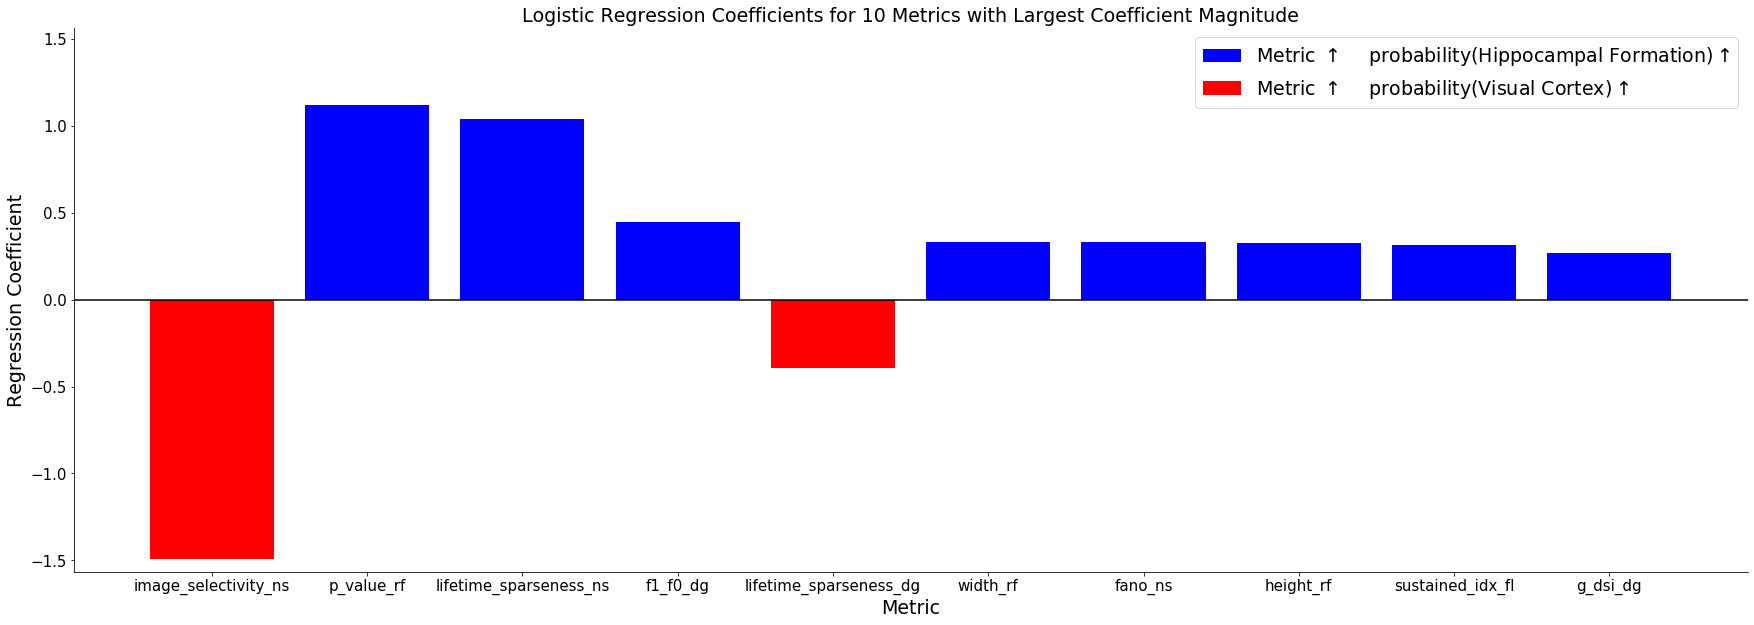

In [16]:
'''
1- Print the summary of logistic coefficient model
2- Plot the coefficient values with 10 largest amplitude to a bar graph (and save as png file)
'''


number_of_coefficients_plot=10 # parameter to select the number of coefficients to plot
y_axis_display_margin=0.05

#Print Logistic Regression Model Summary
print('Summary for Logistic Regression Model')
print(bo_log_res_model.summary())


#Print Logistic Regression Coefficients (10 coefficients with highest amplitudes)
bo_log_res_model_coef=bo_log_res_model.params

bo_log_res_model_coef_sort=(bo_log_res_model_coef.abs()).sort_values(axis=0,ascending=False)
bo_log_res_model_coef_sort_with_sign=bo_log_res_model_coef[bo_log_res_model_coef_sort.keys()]

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
plt.figure(figsize=(30,10),frameon=False)

ax1=plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


label_pos=[]
value_pos=[]
x_axis_pos=[]
label_neg=[]
value_neg=[]
x_axis_neg=[]


for coef_rank in range(0,number_of_coefficients_plot):
  log_res_coef=bo_log_res_model_coef_sort_with_sign.iloc[coef_rank]
  log_res_coef_key=(bo_log_res_model_coef_sort_with_sign.keys())[coef_rank]
  if log_res_coef>=0:
    label_pos.append(log_res_coef_key)
    value_pos.append(log_res_coef)
    x_axis_pos.append(coef_rank)
  else:
    label_neg.append(log_res_coef_key)
    value_neg.append(log_res_coef)
    x_axis_neg.append(coef_rank)

plt.bar(np.asarray(x_axis_pos),np.squeeze(np.asarray(value_pos)),width=0.8,tick_label=label_pos,color='b',label=r'Metric $\uparrow$    probability(Hippocampal Formation)$\uparrow$')
plt.bar(np.asarray(x_axis_neg),np.squeeze(np.asarray(value_neg)),width=0.8,tick_label=label_neg,color='r',label=r'Metric $\uparrow$    probability(Visual Cortex)$\uparrow$')
matplotlib.pyplot.xticks(ticks=np.arange(0,10),labels=bo_log_res_model_coef_sort_with_sign.keys()[:10])
plt.legend(fontsize=19)
plt.ylabel('Regression Coefficient',fontsize=19)
plt.xlabel('Metric',fontsize=19)
plt.title('Logistic Regression Coefficients for 10 Metrics with Largest Coefficient Magnitude',fontsize=19)

plt.ylim((-1-y_axis_display_margin)*bo_log_res_model_coef_sort_with_sign.abs().max(),(1+y_axis_display_margin)*bo_log_res_model_coef_sort_with_sign.abs().max())
plt.axhline(color='k')
plt.savefig('/tmp/AllenBrainDataset/Brain_Obsevatory_Log_Reg_Coef.png',dpi=600)


Visual display to compare the testing accuracy from Brain Observatory 1.1 vs Functional Connectivity Datasets using 3 different models (Logistic Regression, Gradient Boosting, Deep Neural Network).  

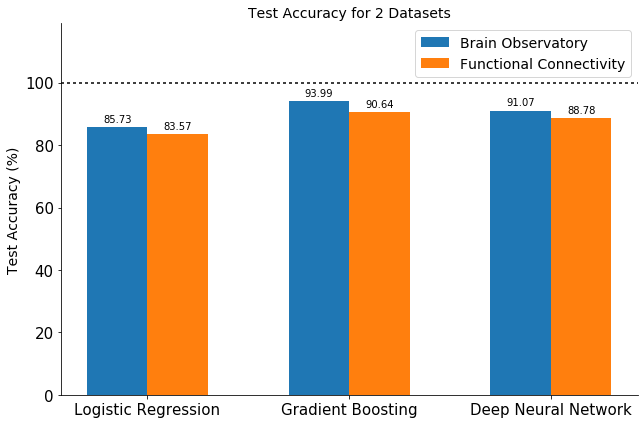

In [17]:
'''
Display test accuracy for 2 datasets (Brain Observatory 1.1 vs Functional Connectivity) using 3 different models (Logistic Regression, Gradient Boosting, Deep Neural Network)
'''

method_label=['Logistic Regression','Gradient Boosting','Deep Neural Network']
bo_test_acc=[bo_log_res_performance['test_accuracy']*100,bo_grad_boost_performance['test_accuracy']*100,bo_dnn_performance['test_accuracy']*100]
fc_test_acc=[fc_log_res_performance['test_accuracy']*100,fc_grad_boost_performance['test_accuracy']*100,fc_dnn_performance['test_accuracy']*100]

method_x_pos=np.arange(len(method_label))
width = 0.3

fig_test_acc, ax_test_acc = plt.subplots(figsize=(9,6),frameon=False)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

bo_bars = ax_test_acc.bar(method_x_pos - width/2, bo_test_acc, width, label='Brain Observatory')
fc_bars = ax_test_acc.bar(method_x_pos + width/2, fc_test_acc, width, label='Functional Connectivity')

ax_test_acc.set_ylabel('Test Accuracy (%)',fontsize=14)
ax_test_acc.set_title('Test Accuracy for 2 Datasets',fontsize=14)
ax_test_acc.set_xticks(method_x_pos)
ax_test_acc.set_xticklabels(method_label)
ax_test_acc.legend(fontsize=14)

def acc_label(bars):
    """Create a text label representing accuracy"""
    for current_bar in bars:
        height = current_bar.get_height()
        ax_test_acc.annotate('%.2f'%height,
                    xy=(current_bar.get_x() + current_bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


acc_label(bo_bars)
acc_label(fc_bars)

fig_test_acc.tight_layout()

plt.axhline(y=100,color='k',dashes=(2,2))

ax_test_acc.spines['top'].set_visible(False)
ax_test_acc.spines['right'].set_visible(False)
plt.ylim(0,119)

plt.savefig('/tmp/AllenBrainDataset/Brain_Obsevatory_vs_Functional_Connectivity.png',dpi=600)

#6 - Conclusions
Here, we predicted the brain region of brain cells based on their electrophysiological activity. We have used the recently released [Allen Brain Neuropixels  Dataset](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html). The goal was defined as a classification problem between two brain regions (Visual Cortex or Hippocampal Formation), which dominate (in sample size) the datasets. 
- Classification accuracy as high as 94% (on test set) is achieved (from Brain Observatory Dataset, using Gradient Boosting). This highlights that electrical activity contains rich information about brain cells;associated brain region in this case. 
- Overall, the performance (accuracy or f1 score) of Gradient Boosting was best, followed by a Deep Neural Network, that followed by Logistic Regression. 
- From two datasets with different experimental protocols, predictions using Brain Observatory 1.1 was more successful than Functional Connectivity Dataset.
- The coefficients from logistic regression suggest that some of the predictors with high coefficients are plausible, given the current scientific knowledge. Whereas, coefficients associated with some predictors were harder to interpret,possibly due to nonlinear dependicies across predictors.

**To sum up, physiological data contains rich information and reflects the address of a cell in the brain, as shown here using the [Allen Brain Neuropixels  Dataset](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html).**